#### In this notebook the profiling of the Cayula Cornillon algorithm is performed. Several tests and try and error exercices are made in order to  reduce the time the program takes to run and its complexity 

In [1]:
#Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
import xarray as xr
import os
from pathlib import Path
from numpy import nanmedian
import scipy
import scipy.signal
import math
from numpy.fft import fft2
import cmocean
import cv2
import matplotlib

import pstats
from time import time
from pstats import SortKey
import cProfile
from line_profiler import LineProfiler

plt.rcParams["figure.figsize"] = 14, 12
%matplotlib inline

## Import Data


In the data directory there are several netCDF files with MUR and Reanalysis data.

In [2]:
def get_data(data):
    
    """
    Function to get our netCDF file that is stored in the data directory and convert it to a dataframe.
    The data parameter is the string name of the netCDF file we want to import
    """
    
    current_path = os.getcwd()
    data_folder = os.path.join(current_path,"../data")
    
    nc_path = os.path.join(data_folder, data)
    ds = nc.Dataset(nc_path)
    netCDF = xr.load_dataset(nc_path)
    
    df = netCDF.to_dataframe()
    df = df.reset_index()
    
    df = df.drop(['depth'], axis=1, errors='ignore') #drop the column 'depth' if exists: only exists in reanalysis
    
    #caso se esteja a importar os dados do MUR, renomear as colunas e passar a temperatura para Celsius
    if data.startswith('mur'):
        df.rename(columns={'lat': 'latitude', 'lon': 'longitude', 'time': 'time', 'analysed_sst':'thetao'}, inplace=True)
        df['thetao'] = df['thetao']-273.15   
        
    
    return df

In [3]:
#Import the netCDF of MUR data from August 2019 and convert it to a dataframe
df_mur_aug = get_data('murAugust2019.nc')

In [4]:
df_mur_aug

,latitude,longitude,time,thetao
0,35.0,-19.0,2019-08-01 09:00:00,22.830994
1,35.0,-19.0,2019-08-02 09:00:00,23.727997
2,35.0,-19.0,2019-08-03 09:00:00,24.345001
3,35.0,-19.0,2019-08-04 09:00:00,24.382996
4,35.0,-19.0,2019-08-05 09:00:00,24.256012
...,...,...,...,...
43474426,45.0,-5.0,2019-08-27 09:00:00,19.819000
43474427,45.0,-5.0,2019-08-28 09:00:00,20.588013
43474428,45.0,-5.0,2019-08-29 09:00:00,20.716003
43474429,45.0,-5.0,2019-08-30 09:00:00,20.743988


In [5]:
#dataframe with data from 1st August 2019 for the MUR data
Aug1_mur = df_mur_aug[df_mur_aug['time'] == '2019-08-01 09:00:00']

In [6]:
def get_period(df):
    
    """
    Function that receives a dataframe that has SST data for different days 
    and returns a dictionaire of dataframes (one for each different day) (dict_df) and 
    an array with the different dates its possible to find in our dataframe (specificday)
    """
    
    specificday = [pd.Timestamp(dd).strftime("%Y-%m-%d %H:%M:%S") for dd in df['time'].unique()]
    specificday = np.array(specificday, dtype=np.object)
  
    #create a dictionary to store the data frames for each day
    dict_df = {elem : pd.DataFrame for elem in specificday}

    for key in dict_df.keys():
        dict_df[key] = df[:][df['time'] == key]
        
    return dict_df, specificday

#after this function we only have to define the period we want to analyse

In [7]:
dict_df_mur_aug, specificday_mur_aug = get_period(df_mur_aug)
#dict_df_mur_aug -> dictionaire of dataframes for each day of August 2019 of the MUR data
#specificday_mur_aug -> array with all the days of August 2019

## Cayula-Cornillon Algorithm

In [9]:
def getFrontInWindow(w, head, minTheta, minPopProp, minPopMeanDiff, minSinglePopCohesion, 
                     minGlobalPopCohesion, corners):
    
    """
    This functions detects fronts in slidding windows. If a front is detected, the function will return
    2 1D arrays (x and y) with the coordinate values corresponding to the location of the front.
    """
    
    #empty arrays de xdata, ydata e z
    xdata = np.array([])
    ydata = np.array([])
    z = np.array([])
    exitType=0
    
    #mask is an array with the same shape of w, that is 1 if in that index position w = np.nan and 0 otherwise
    mask = np.isnan(w).astype('int')  
    haveNaNs = np.any(mask[:]).astype('int')  #haveNaNs=1 if mask has 1s (that correspond to NaNs in matrix w)
    n_NaNs=0
    
    
    if haveNaNs:
        n_NaNs = sum(mask.flatten()[:])       # count nr of 1s (NaNs in matrix w) that there are
        if (n_NaNs/len(w.flatten())>0.5):     #window can't have more than 50% of its pixels as NaNs
            exitType=-1
            return None,None,None,exitType  
        
    mi_ma = [np.nanmin(w), np.nanmax(w)]                          #array with minimum and maximum value of w
    n = math.ceil((mi_ma[1]-mi_ma[0])/0.02)                       #number of bins
    bins = np.arange(mi_ma[0], mi_ma[1], 0.02)                    #to define the bins sequence 
    [y, xout] = np.histogram(w[:], bins, mi_ma)                   #y->frequency counts, Xout->bin location
    xout = np.mean(np.vstack([xout[0:-1],xout[1:]]), axis=0)     #xout to be relative to the centers of the bins
    
    
    thresValue = xout[0]        
    totalCount = len(w.flatten()) - n_NaNs    #nr of non NaN pixels 
    threshPopACount = 0
    threshSeparation = -1
    threshPopAMean = 0
    threshPopBMean = 0
    
    w[mask==1] = 0                      #Replace NaNs with 0's (when mask is 1 replace values of array w for 0)
    totalSum = sum(w.flatten())                      #sum of values of matrix w
    totalSumSquares = sum(w.flatten()*w.flatten())   #sum of the squares of the values of w
    
    #In this for loop we are going to discover which line is going to make the best separation between the average
    # of population on the left and on the right (A and B) - and that is going to be the thresValue
    for k in range(1,n-1):     #ignore the first and last candidates (senão seria de 0 a n)
        popASum = sum(y[0:k+1] * xout[0:k+1])    
        popBSum = sum(y[k+1:] * xout[k+1:])  
        popACount = sum(y[0:k+1])     #sum of frequencies (y) from populationA
        popBCount = sum(y[k+1:])      #sum of frequencies (y) from populationB
    
        popAMean = popASum/popACount
        try:                                  #to avoid the zerodivisionerror that was poping up 
            popBMean = popBSum/popBCount
        except ZeroDivisionError:
            popBMean = 0
        separation = popACount * popBCount * (popAMean - popBMean) * (popAMean - popBMean)
        if separation>threshSeparation:
            threshSeparation = separation
            thresValue = xout[k]
            threshPopACount = popACount
            threshPopAMean = popAMean
            threshPopBMean = popBMean
            
         
        #abort in case the proportion of population A is less that a certain minimum
    if (threshPopACount / totalCount < minPopProp):
        exitType = 1
        return None,None, None, exitType  
    
    #abort in case the proportion of population B is less that a certain minimum
    if (1.0 - threshPopACount / totalCount < minPopProp):
        exitType = 1
        return None,None,None, exitType  
    
    #abort this window if the difference in the populations means is less than a minimum value
    if (threshPopBMean - threshPopAMean < minPopMeanDiff):   
        exitType = 2
        return None,None,None,exitType  
    
    #Calculate the criterion function THETA (TAUopt) in page 72 of the paper
    totalMean = totalSum/totalCount
    variance = totalSumSquares - (totalMean * totalMean * totalCount)
    theta = threshSeparation / (variance * totalCount)
    if (theta < minTheta):         #abort if theta is lower than a certain minimum  
        exitType = 3
        return None,None,None,exitType  
    
#Cohesion - now that we know the separation value. Based on this value we will check the matrix element by 
#element, and check whether is bigger or lower than the separation  
#we check if it's bigger bellow or to the right (when its bigger we add from one side, when its lower add to the other)
#Count the nr of times a population A cell is immediately adjacent to another popA cell and the same for popB
# A cell can be adjacent on 4 sides. Count only 2 of them (bottom and right side) because doing all 4 would be
#redundant. Do not count diagonal neighbors
    countANextToA = 0
    countBNextToB = 0
    countANextToAOrB = 0
    countBNextToAOrB = 0
    [n_rows, n_cols] = w.shape
    for col in range(0, n_cols-1):
        for row in range(0, n_rows-1):
            if (haveNaNs & (mask[row, col] | mask[row+1, col] | mask[row, col+1])):
                continue
                         
            #examine the bottom neighbor
            if (w[row, col] <= thresValue):                  #if matrix pixel < than the element of separation
                countANextToAOrB = countANextToAOrB + 1      #increase by 1 countANextToAOrB
                if (w[row+1, col] <= thresValue):            #if pixel of bottom row < than separation
                    countANextToA = countANextToA + 1        #increase countANextToA
            else:                                            #if pixel > than separation 
                countBNextToAOrB = countBNextToAOrB + 1      #increase countBNextToAOrB
                if (w[row+1, col] > thresValue):             #if pixel of bellow row > separation
                    countBNextToB = countBNextToB + 1        #increase countBNextToB
                         
                         
            # Examine the right neighbor
            if (w[row, col] <= thresValue):                     #if matrix pixel < separation      
                countANextToAOrB = countANextToAOrB + 1         # increase countANextToAOrB
                if (w[row, col+1] <= thresValue):               #if right pixel < separation
                    countANextToA = countANextToA + 1           # increase countANextToA
            else:                                               #if matrix pixel > separation
                countBNextToAOrB = countBNextToAOrB + 1         #increase countBNextToAOrB
                if (w[row, col+1] > thresValue):                #if right pixel > separation
                    countBNextToB = countBNextToB +1            # increase countBNextToB
                         
                         
    popACohesion = countANextToA / countANextToAOrB
    popBCohesion = countBNextToB/ countBNextToAOrB
    globalCohesion = (countANextToA + countBNextToB) / (countANextToAOrB + countBNextToAOrB)
    
    #These ifs are in case of errors (parameters below certain limits)
    if (popACohesion < minSinglePopCohesion):
        exitType = 4
        return None, None,None,exitType  
                         
    if (popBCohesion < minSinglePopCohesion):
        exitType = 4
        return None, None, None,exitType  
                         
    if (globalCohesion < minGlobalPopCohesion):
        exitType = 4
        return None, None, None,exitType  
                         
                         
    #OK if we reach here we have a front. Compute its contour
    X = np.linspace(head[0], head[1], n_cols)    
    Y = np.linspace(head[2], head[3], n_rows)
    if (corners.size == 0):
        w = w.astype('double')    
        if haveNaNs:
            w[w==0] = np.nan      # Need to restore the NaNs to not invent new contours around zeros
        
        c = plt.contour(X, Y, w, [thresValue])    #Create and store a set of contour lines or filled regions.
    else:
        #the 4 corners have these indices [17,32,17,32; 17,32,1,16; 1,16,1,16;1,16,17,32]
        # and the variable corners has one of its rows (the current to be retained sub-window)
        
        X = X[np.arange(corners[2]-1, corners[3])]
        Y = Y[np.arange(corners[0]-1, corners[1])]
        w = w[np.arange(corners[0], corners[1]).min()-1:np.arange(corners[0], corners[1]).max()+1, np.arange(corners[2], corners[3]).min()-1:np.arange(corners[2], corners[3]).max()+1]
        
        if  haveNaNs:
            w[w==0] = np.nan     # Need to restore the NaNs to not invent new contours around zeros
                         
        if (np.isnan(w)).all()==True:
            c = np.array([])
        else:
            c = plt.contour(X, Y, w, [thresValue])     #Create and store a set of contour lines or filled regions.
                     
           
        try:
            M = c.allsegs[:]          #list of arrays for contour c. Each array corresponds to a line that may or may not be drawn. This list can have any number of arrays
        except:
            M = []
            
        M = [x for x in M if x]   #if the list has empty arrays we will drop them
        
        count = 0   #to iterate through the various arrays
        
        #Create list of booleans (True or False) wether the conditions bellow are fulfilled
        # Each array (line of contour) must have more that 7 data points and they can't be closed lines
        lista = []     
        for i in range(len(M[:])):
            lista.append([(len(x)<7 or (x[0][0]==x[-1][0] and x[0][1] == x[-1][1])) for x in M[:][i]])
            
            #if False the line will be drawn
            #if True the line will be ignored
            
        for value in lista:
            if value == [True]:
                continue        #return to the top of the for loop
            else:
        
                #For the first array of M we will take all the values of x and put them into an array
                x = []
                for i in range(len(M[:][count][0])):
                    x.append((M[:][count][0][i][0]).round(4))
                
                #For the first array of M we will take all the values of y and put them into an array
                y = []
                for i in range(len(M[:][count][0])):
                    y.append((M[:][count][0][i][1]).round(4))
                
                
                #save the x and y data points for each line in an xdata and ydata array
                xdata = np.append(xdata, x)    
                ydata = np.append(ydata, y)

                count = count + 1
            
        
        z = thresValue
        
        if (xdata.size == 0):
            exitType = 5;
            
    return xdata, ydata, z, exitType
        

In [13]:
def CCA_SIED(df):
    
    """
    This function applies the Cayula-Cornillon Algorithm Single Image Edge Detector (CCA_SIED) to a single image
    df - dataframe in which the CCA_SIED will be applied. This datafram has a column for the longitude,
    latitude and SST values. 
    For a single image, the function return the fronts coordinates (x,y) points 
    """
    
    #convert the latitude and longitude columns to a numpy array
    lat = df['latitude'].to_numpy()
    lon = df['longitude'].to_numpy()
    
    lat = np.unique(lat).round(3)        #get the unique values of the latitude array
    lon = np.unique(lon).round(3)        #get the unique values of the longitude array
    
    #get the sst values as a grid acording to the longitude (nr of rows) and latitude (nr of columns)
    sst = df.pivot_table(index='longitude', columns='latitude', values='thetao').values.round(4)
    
    lat_min = lat.min()     
    lat_max = lat.max()
    lon_min = lon.min()
    lon_max = lon.max()

    lat_unique = len(np.unique(lat))    # nr of different latitude points
    lon_unique = len(np.unique(lon))    #nr of different longitude points

    X = np.linspace(lon_min, lon_max, lon_unique)        #linearly spaced vector with the longitude points
    Y = np.linspace(lat_min, lat_max, lat_unique)        #linearly spaced vector with the latitude points
    X, Y = np.meshgrid(X, Y)                 #create a rectangular grid out of two given one-dimensional arrays

    lat, lon = np.meshgrid(lat, lon)            

    from scipy.interpolate import griddata
    Z = griddata((lon.flatten(), lat.flatten()), sst.flatten(), (X,Y), method='linear')  
    
    head = np.array([lon_min, lon_max])           #Extremos do array que se obtem com a meshgrid em X
    head = np.append(head, [lat_min, lat_max])   #Extremos do array que se obtem com a meshgrid em Y

    z_dim = Z.shape    #dimensões da matriz Z (rows, cols)

    z_actual_range = np.array([np.nanmin(Z[:]), np.nanmax(Z[:])])    #range dos dados (valor minimo e maximo da matriz Z)
    nx = z_dim[1]      # number of columns of matrix Z
    ny = z_dim[0]      # number of rows of matrix Z
    node_offset = 0
    
    #index 4 -> menor valor de Z; index5 -> maior valor de Z; index6 -> node_offset=0
    head = np.append(head, np.array([z_actual_range[0], z_actual_range[1] , node_offset]))    
    head = np.append(head, np.array((head[1]- head[0])/(nx - int(not node_offset))))     
    head = np.append(head, np.array((head[3]- head[2])/(ny - int(not node_offset))))     
    head = head.astype('float')

    
    #cayula
    minPopProp = 0.20        #minimum proportion of each population
    minPopMeanDiff = 0.4     # minimum difference between the means of the 2 populations
    minTheta = 0.70
    minSinglePopCohesion = 0.90
    minGlobalPopCohesion = 0.70
    
    
    [n_rows, n_cols] = Z.shape       #nr of rows and columns of matrix Z
    winW16 = 16
    winW32 = 16*2
    winW48 = 16*3


    #arrays that will store the contour of every front that will be detected
    xdata_final = np.array([])
    ydata_final = np.array([])

    s=0 #s=1 means subwindows do NOT share a common border. With s = 0 they do.

    xSide16 = winW16*head[7]
    ySide16 = winW16*head[8]
    xSide32 = (winW32 - s) * head[7]
    ySide32 = (winW32 - s) * head[8]

    nWinRows = math.floor(n_rows/winW16)   #times a window can slide over the rows 
    nWinCols = math.floor(n_cols/winW16)   #times a window can slide over the columns


    for wRow in range(1, nWinRows-1):    
        #start and stop indices and coords of current window
        r1 = (wRow-1) * winW16 + 1
        r2 = r1 + winW48 -s     
    
        y0 = head[2] + (wRow-1)*ySide16    #y1 = y0 + (winW48-1)*head[8]
    
        for wCol in range(1, nWinCols-1):     
            c1 = (wCol - 1)*winW16+1
            c2 = c1 + winW48 - s
            x0 = head[0] + (wCol-1) * xSide16     #x1 = x0 + (winW48-1)*head[7]
            wPad = Z[r1-1:r2, c1-1:c2]            # 49x49 (or 48x48 if s == 1) Window
        
            rr = np.array([1,1,2,2])
            cc = np.array([1,2,2,1])
        
            if s==1:
                corners = np.array([[17, 32, 17, 32], [17, 32, 1, 16], [1, 16, 1, 16], [1, 16, 17, 32]])  #less good
            else:
                corners = np.array([[17, 33, 17, 33], [17, 33, 1, 17], [1, 17, 1, 17], [1, 17, 17, 33]])
            
            for k in range(0,4):     #loop over the 4 slidding 32X32 sub-windows of the larger 48x48 one
                m1 = (rr[k] - 1) * winW16 + 1
                m2 = m1 + 2 * winW16 - s             #indices of the slidding 33X33 window
                n1 = (cc[k] - 1) * winW16 + 1
                n2 = n1 + 2 * winW16 - s
            
                w = wPad[m1-1:m2, n1-1:n2].astype('double')      #sub window with size 33x33
            
                #corners coordinates
                subWinX0 = x0 + (cc[k] - 1) * xSide16
                subWinX1 = subWinX0 + xSide32
                subWinY0 = y0 + (rr[k] - 1) * ySide16
                subWinY1 = subWinY0 + ySide32
            
                R = np.array([subWinX0, subWinX1, subWinY0, subWinY1])
          
                xdata, ydata, z, exitType = getFrontInWindow(w, R, minTheta, minPopProp, minPopMeanDiff, minSinglePopCohesion, minGlobalPopCohesion, corners[k,:])
            
                if (exitType == 0):
                   
                    xdata_final = np.append(xdata_final, xdata)
                
                    ydata_final = np.append(ydata_final,ydata)
    
    
    
    #plt.plot(xdata_final, ydata_final, color="red", linewidth=0.5)
    #plt.imshow(np.flipud(Z), extent=extent)
    #plt.rcParams["figure.figsize"] = 12, 8
    #plt.colorbar(fraction=0.036, pad=0.04)
    #plt.show()
    
    return xdata_final, ydata_final
    


In [20]:
def front_calc(df): 
    
    """
    Function that calculates the fronts matrix. Given an image (SST data respective to one day) it applies the
    Cayula-Cornillon Algorithm for Single Image Edge Detection (CCA-SIED) to discover the fronts.
    It returns the matrix with the fronts: if pixel = 1 it was considered a front, otherwise, pixel = 0
    It basically converts the (x,y) coordinate points to indexes of the frontal probability matrix. These indexes are considered fronts
    The df parameter is the dataframe with the SST data for a certain day
    """  
    
    front = np.zeros((1001,1401))       #inittialize a matrix of zeros. This shape is for the MUR data
    

    #2 empty arrays that will store the x and y values of the lines that are suposed to be drawn
    x = np.array([])
    y = np.array([])
    
    lat = np.array(df['latitude'].unique())
    lon = np.array(df['longitude'].unique())
        
    xdata_final, ydata_final = CCA_SIED(df)       
    x = np.append(x, xdata_final)
    y = np.append(y, ydata_final)
    
        
    
    cols_x = np.array([])
    for value in x:                     #convert values in array x to the respective index in a (1001, 1401) matrix
        aux_x = (19+value)/0.01                  #these numbers are relative to the MUR data
        cols_x = np.append(cols_x, aux_x)
    
    rows_y = np.array([])
    for value in y:                     #convert values in array y to the respective index in a (1001, 1401) matrix
        aux_y = (45-value)/0.01                  #these numbers are relative to the MUR data
        rows_y = np.append(rows_y, aux_y)
     

    cols_x = np.round(cols_x)
    rows_y = np.round(rows_y)
            
    for i in range(len(cols_x)):   #it could also be len(rows_y)
        front[int(rows_y[i]), int(cols_x[i])] = front[int(rows_y[i]), int(cols_x[i])] + 1
            
        
    front[front != 0] = 1
    
    return front
            

In [25]:
def frontal_prob(period, dict_df):
    
    """
    Function that allows the visualization of the Frontal Probabilities for the Cayula-Cornillon Algorithm (CCA).
    It receives 2 parameters: period (its an array with the several dates for the period in question) and
    days (which is a dictionaire of dataframes) with data related.
    This function also applies a mask to the frontal probabilities array in order for the continental zone to be 
    well defined. The function plots the frontal probabilities
    """
    front_prob = np.zeros((1001, 1401))
    for day in period:
        front = front_calc(dict_df[day])
        
        front_prob = front_prob + front
        
    front_prob = front_prob/(len(period))*100

    
    #Create a masked_array for the study zone in order to get the continental zone well defined
    
    #Convert some df to a numpy array with the SST values for each value of longitude and latitude
    sst = dict_df[period[0]].pivot_table(index='longitude', columns='latitude', values='thetao').T.values    
    mask = np.isnan(np.flipud(sst))    #Boolean array is True where original array (Temp) had Null values
    mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array which pixels = 255 when mask=True
    #Make a dilation on the continental area
    kernel = np.ones((3,3), np.uint8)
    mask_dilated = cv2.dilate(mask255, kernel)
    
    
    front_prob = np.ma.masked_where(mask_dilated==255, front_prob)
    
    
    return front_prob

In [22]:
@performance    #decorator defined bellow to acess the time that the function takes to run
def CCA_visualization(period, dict_df):
    
    """
    Function that allows the visualization of the Frontal Probabilities for the Cayula-Cornillon Algorithm (CCA).
    It receives 2 parameters: period (its an array with the several dates for the period in question) and
    days (which is a dictionaire of dataframes) with data related.
    This function also applies a mask to the frontal probabilities array in order for the continental zone to be 
    well defined. The function plots the frontal probabilities
    """

    fp = frontal_prob(period, dict_df)
    
    
    #Create a masked_array for the study zone in order to get the continental zone well defined
    
    #Convert some df to a numpy array with the SST values for each value of longitude and latitude
    sst = dict_df[period[0]].pivot_table(index='longitude', columns='latitude', values='thetao').T.values  #MELHORAR  
    mask = np.isnan(np.flipud(sst))    #Boolean array is True where original array (Temp) had Null values
    mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array which pixels = 255 when mask=True
    #Make a dilation to ensure the pixels that belong to the shore are not consideredd fronts
    kernel = np.ones((3,3), np.uint8)
    mask_dilated = cv2.dilate(mask255, kernel)
    
    fp = np.ma.masked_where(mask_dilated==255, fp)
    
    lat = dict_df[period[0]]['latitude'].to_numpy()
    lon = dict_df[period[0]]['longitude'].to_numpy()
    lat = np.unique(lat).round(3)
    lon = np.unique(lon).round(3)
        
        
    plt.rcParams["figure.figsize"] = (12, 10)
    img = plt.imshow(fp,cmocean.cm.thermal, extent=[lon[0], lon[-1], lat[0], lat[-1]])    
    #extent serve para definir a extensão do eixo dos x e dos y
    plt.title("Map of frontal probability", fontsize=20)
    plt.show()
    

/tmp/ipykernel_3095/3192969404.py:164: UserWarning: No contour levels were found within the data range.
  c = plt.contour(X, Y, w, [thresValue])     #Create and store a set of contour lines or filled regions.
/tmp/ipykernel_3095/3192969404.py:50: RuntimeWarning: invalid value encountered in double_scalars
  popBMean = popBSum/popBCount


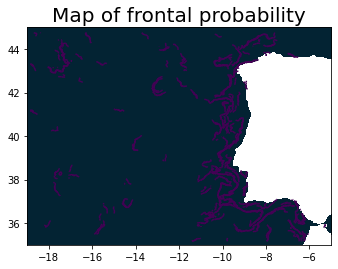

In [36]:
CCA_visualization(specificday_mur_aug[:1], days_mur_aug)

### Profiling

Procede to several techniques to evaluate the performance of the code

In [23]:
#Evaluate the time a function takes to run by using a decorator -> Just for Sport
def performance(function):
    def wrapper(*args, **kwargs):      #flexible -> *args and **kwargs because we don't know how many parameters
        t1 = time()
        result = function(*args, **kwargs)       
        t2 = time()
        print(f'It took {t2-t1} s to run the code')
        return result
    return wrapper

/tmp/ipykernel_87004/1236468573.py:169: UserWarning: No contour levels were found within the data range.
  c = plt.contour(X, Y, w, [thresValue])     #Create and store a set of contour lines or filled regions.
/tmp/ipykernel_87004/1236468573.py:55: RuntimeWarning: invalid value encountered in double_scalars
  popBMean = popBSum/popBCount


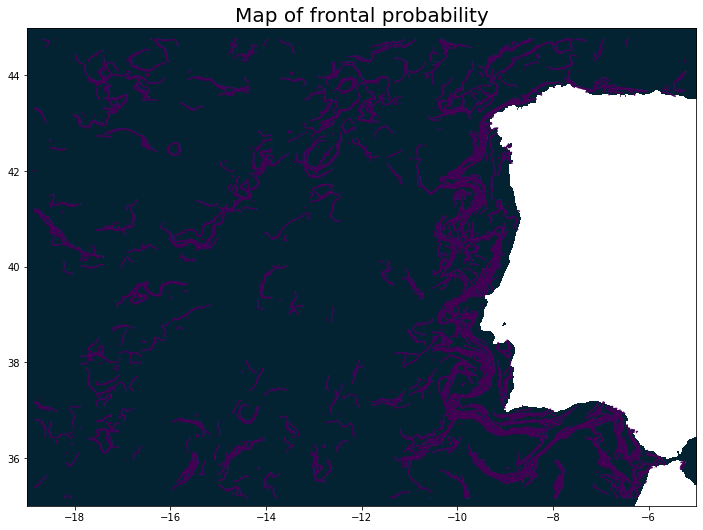

It took 285.60433197021484 s to run the code


In [28]:
from time import time

CCA_visualization(specificday_mur_aug[:4], dict_df_mur_aug)

When I test for 1 image the time it takes is 44.7s.
* For 2 days of data -> 104.5s
* For 4 days of data -> 285.6s

Claramente com o aumento de dados, o tempo de computação aumenta não linearmente.

##### CProfile -> it hooks into the virtual machine to measure the time taken to run certain functions

/tmp/ipykernel_87004/1236468573.py:169: UserWarning: No contour levels were found within the data range.
  c = plt.contour(X, Y, w, [thresValue])     #Create and store a set of contour lines or filled regions.
/tmp/ipykernel_87004/1236468573.py:55: RuntimeWarning: invalid value encountered in double_scalars
  popBMean = popBSum/popBCount


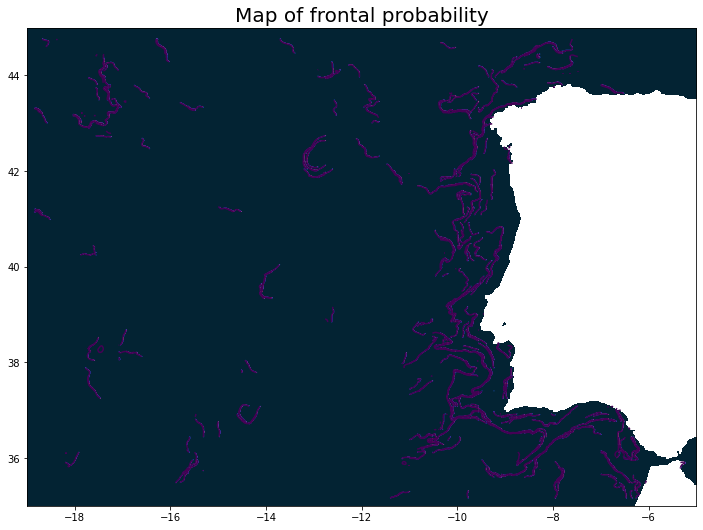

It took 51.618807315826416 s to run the code
         18432856 function calls (18081567 primitive calls) in 51.619 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    20400    4.860    0.000   26.706    0.001 1236468573.py:1(getFrontInWindow)
     1658    0.001    0.000    0.001    0.000 1236468573.py:177(<listcomp>)
     1657    0.002    0.000    0.002    0.000 1236468573.py:185(<listcomp>)
        1    0.052    0.052   49.943   49.943 2629165481.py:1(front_calc)
        1    0.003    0.003   51.619   51.619 3213285787.py:1(CCA_visualization)
        1    0.262    0.262   49.589   49.589 407091482.py:1(CCA_SIED)
        1    0.007    0.007   50.301   50.301 4284452679.py:1(frontal_prob)
        1    0.000    0.000   51.619   51.619 811938150.py:3(wrapper)
     5004    0.002    0.000    0.018    0.000 <__array_function__ internals>:2(all)
    50254    0.019    0.000    0.187    0.000 <__array_function__ internals>:2(amax)
 

     1658    0.003    0.000    0.011    0.000 collections.py:662(set_antialiased)
     3316    0.005    0.000    0.015    0.000 collections.py:691(_set_facecolor)
     1658    0.002    0.000    0.010    0.000 collections.py:704(set_facecolor)
     6632    0.001    0.000    0.001    0.000 collections.py:719(get_facecolor)
     6632    0.002    0.000    0.004    0.000 collections.py:722(get_edgecolor)
     4974    0.023    0.000    0.126    0.000 collections.py:728(_set_edgecolor)
     3316    0.003    0.000    0.098    0.000 collections.py:756(set_edgecolor)
     1658    0.003    0.000    0.043    0.000 collections.py:769(set_alpha)
     3316    0.000    0.000    0.000    0.000 collections.py:782(update_scalarmappable)
     1658    0.019    0.000    0.282    0.000 collections.py:90(__init__)
     4979    0.005    0.000    0.022    0.000 colors.py:1050(autoscale_None)
     6634    0.001    0.000    0.001    0.000 colors.py:113(_sanitize_extrema)
    10172    0.005    0.000    0.021    0.

6893/3514    0.010    0.000    0.038    0.000 transforms.py:2387(get_affine)
     6662    0.006    0.000    0.017    0.000 transforms.py:2408(__init__)
     6662    0.005    0.000    0.014    0.000 transforms.py:2451(get_matrix)
    18473    0.011    0.000    0.054    0.000 transforms.py:2462(composite_transform_factory)
     1682    0.003    0.000    0.008    0.000 transforms.py:2544(__init__)
11762/11761    0.003    0.000    0.013    0.000 transforms.py:2564(get_matrix)
        1    0.000    0.000    0.000    0.000 transforms.py:2606(__init__)
     3345    0.000    0.000    0.000    0.000 transforms.py:2622(get_matrix)
      122    0.000    0.000    0.000    0.000 transforms.py:2644(__init__)
      179    0.000    0.000    0.000    0.000 transforms.py:2658(get_matrix)
       24    0.000    0.000    0.000    0.000 transforms.py:2681(__init__)
       24    0.000    0.000    0.000    0.000 transforms.py:2696(_revalidate)
       24    0.000    0.000    0.000    0.000 transforms.py:2709(g

In [30]:
import cProfile

cProfile.run('CCA_visualization(specificday_mur_aug[:1], dict_df_mur_aug)')


* ncalls -> total nr of calls for the function
* tottime -> total time spent inside the function called
* percall -> the average amount of time for each call
* cumtime -> the total time spent inside the function and all other calls made by that function
* percall -> the average time per call (cumtime)

We want to pay attention to: 
    -> functions that not only are called most often but that spend the most time internally (those are the most worth optimizing)
    
In this reports o tottime is very important because now we can zoom in on which functions are the slowest overall. GetFrontInWindow has the biggest tottime so that should be the one that we should optimize.


##### This code uses cProfile to returns 2 documents with metrics regarding the code's performance


/tmp/ipykernel_87004/1236468573.py:169: UserWarning: No contour levels were found within the data range.
  c = plt.contour(X, Y, w, [thresValue])     #Create and store a set of contour lines or filled regions.
/tmp/ipykernel_87004/1236468573.py:55: RuntimeWarning: invalid value encountered in double_scalars
  popBMean = popBSum/popBCount


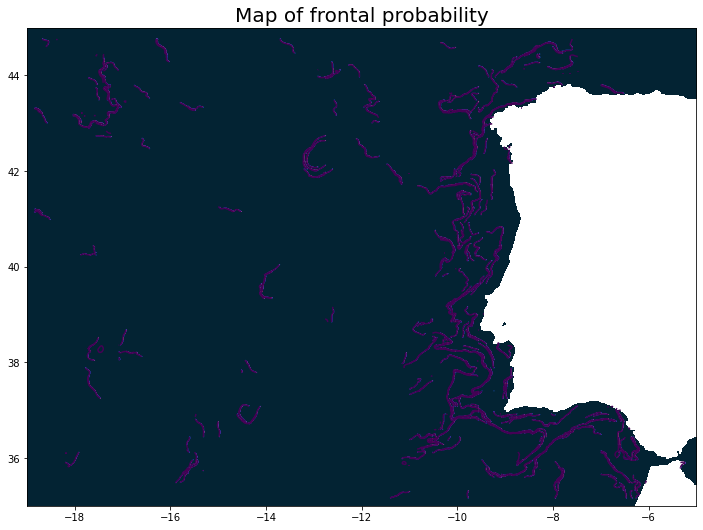

It took 55.22260522842407 s to run the code


In [32]:


cProfile.run('CCA_visualization(specificday_mur_aug[:1], dict_df_mur_aug)', 'output.dat')

import pstats
from pstats import SortKey

with open('output_time.txt', 'w') as f:
    p = pstats.Stats('output.dat', stream=f)
    p.sort_stats('time').print_stats()
    
with open('output_calls.txt', 'w') as f:
    p = pstats.Stats('output.dat', stream=f)
    p.sort_stats('calls').print_stats()

## Line Profiler

In [40]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


/tmp/ipykernel_3095/3192969404.py:164: UserWarning: No contour levels were found within the data range.
  c = plt.contour(X, Y, w, [thresValue])     #Create and store a set of contour lines or filled regions.
/tmp/ipykernel_3095/3192969404.py:50: RuntimeWarning: invalid value encountered in double_scalars
  popBMean = popBSum/popBCount


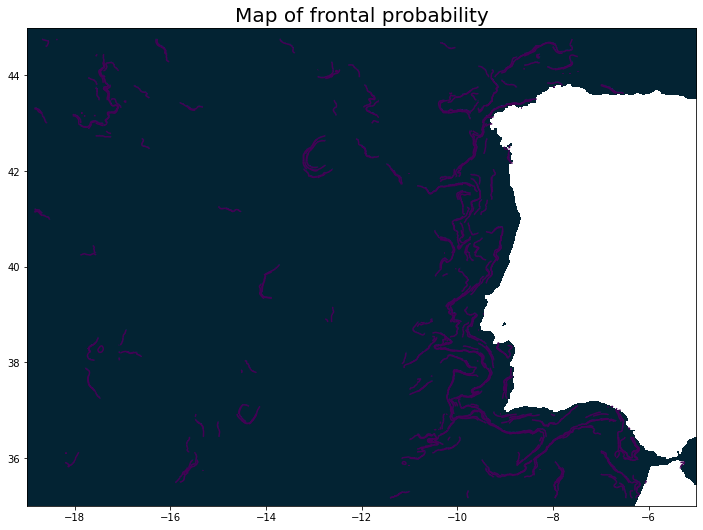

In [42]:
%lprun -f CCA_visualization -f getFrontInWindow CCA_visualization(specificday_mur_aug[:1], days_mur_aug)
#to make a line profiling over (specifically in the getFrontInWindow function) 